<a href="https://colab.research.google.com/github/reshmaamarane/EEG-emotion--AUDIO-BOT/blob/main/MSSEC_GAN_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.4 MB/s eta 0:00:00


In [ ]:
import os
import glob
import numpy as np
import scipy.io
import pywt
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA

# ====== Constants ======
BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 31),
    'gamma': (31, 50)
}
FS = 1000.0
FIXED_LENGTH = 8601

# ====== EEG Processing Functions ======
def bandpass_filter(signal, lowcut, highcut, fs=FS, order=5):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def mspca_denoise(signal, wavelet='db4', level=4, n_components=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    for i in range(1, len(coeffs)):
        coeff = coeffs[i].reshape(-1, 1)
        if coeff.shape[0] < 2:
            continue
        try:
            pca = PCA(n_components=min(n_components, coeff.shape[0]))
            coeff_pca = pca.fit_transform(coeff)
            coeffs[i] = pca.inverse_transform(coeff_pca).flatten()
        except Exception:
            continue
    return pywt.waverec(coeffs, wavelet)[:len(signal)]

def compute_sodp(signal):
    x = np.clip(signal[1:-1] - signal[:-2], -500, 500)
    y = np.clip(signal[2:] - signal[1:-1], -500, 500)
    return x, y

def compute_sdc(x, y):
    return np.mean(np.sqrt(x**2 + y**2))

def extract_sdc_bandwise(signal):
    sdc_features = []
    for _, (low, high) in BANDS.items():
        filtered = bandpass_filter(signal, low, high)
        x, y = compute_sodp(filtered)
        sdc = compute_sdc(x, y)
        sdc_features.append(sdc)
    return np.array(sdc_features)  # (5,)

def process_channel(signal):
    signal = mspca_denoise(signal)
    signal = np.nan_to_num(signal)

    if len(signal) > FIXED_LENGTH:
        signal = signal[:FIXED_LENGTH]
    elif len(signal) < FIXED_LENGTH:
        signal = np.pad(signal, (0, FIXED_LENGTH - len(signal)))

    mean, std = np.mean(signal), np.std(signal)
    signal = (signal - mean) / std if std > 1e-6 else signal - mean

    return extract_sdc_bandwise(signal)  # (5,)

def process_trial(eeg_matrix):
    # eeg_matrix shape: [62, time]
    features = [process_channel(eeg_matrix[ch]) for ch in range(eeg_matrix.shape[0])]
    return np.stack(features).T  # (5, 62)

def process_single_mat(mat_file_path, save_path):
    mat = scipy.io.loadmat(mat_file_path)
    eeg_keys = sorted([k for k in mat if 'eeg' in k and not k.startswith('__')],
                      key=lambda k: int(k.split('eeg')[-1]))

    if len(eeg_keys) != 24:
        raise ValueError(f"Expected 24 EEG trials, found {len(eeg_keys)} in {mat_file_path}")

    all_trials = []
    for key in eeg_keys:
        eeg_matrix = mat[key]  # shape: (62, time)
        trial_features = process_trial(eeg_matrix)
        all_trials.append(trial_features)

    subject_data = np.stack(all_trials)  # (24, 5, 62)
    subject_data = np.clip(subject_data, -1e3, 1e3)

    np.save(save_path, subject_data)
    print(f"✅ Features saved to {save_path} | Shape: {subject_data.shape}")

# ====== Batch Processing All MAT Files in Folders ======
base_dir = '/content/drive/MyDrive/eeg_raw_data'
output_dir = '/content/drive/MyDrive/bandwise_processed'
os.makedirs(output_dir, exist_ok=True)

for session in ['1', '2', '3']:
    session_path = os.path.join(base_dir, session)
    mat_files = glob.glob(os.path.join(session_path, '*.mat'))

    print(f"\n📂 Processing session {session} | Found {len(mat_files)} files")

    for mat_path in mat_files:
        filename = os.path.splitext(os.path.basename(mat_path))[0]
        output_path = os.path.join(output_dir, f'{filename}_bandwise.npy')

        try:
            process_single_mat(mat_path, output_path)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")



In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

# === Fixed channel order ===
ordered_labels = [
    "FP1", "FPZ", "FP2", "AF3", "AF4", "F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8",
    "FT7", "FC5", "FC3", "FC1", "FCZ", "FC2", "FC4", "FC6", "FT8",
    "T7", "C5", "C3", "C1", "CZ", "C2", "C4", "C6", "T8",
    "TP7", "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6", "TP8",
    "P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8",
    "PO7", "PO5", "PO3", "POZ", "PO4", "PO6", "PO8",
    "CB1", "O1", "OZ", "O2", "CB2"
]

# === Load electrode positions from CSV ===
def load_positions(csv_path):
    df = pd.read_csv(csv_path)
    pos_dict = {}
    for _, row in df.iterrows():
        label = row['Electrode'].strip().upper()
        azimuth = np.deg2rad(row['azimuth'])
        inclination = np.deg2rad(row['inclination'])
        x = np.sin(inclination) * np.cos(azimuth)
        y = np.sin(inclination) * np.sin(azimuth)
        pos_dict[label] = (x, y)
    return pos_dict

# === Project a single EEG trial ===
def project_trial(trial_band_data, label_positions, grid_res=32):
    projected = []
    coords = np.array([label_positions[label] for label in ordered_labels])
    for band_data in trial_band_data:  # band_data: shape (62,)
        grid_x, grid_y = np.mgrid[-1:1:grid_res*1j, -1:1:grid_res*1j]
        interpolated = griddata(coords, band_data, (grid_x, grid_y), method='cubic', fill_value=0)
        projected.append(interpolated)
    return np.stack(projected)  # (5, grid_res, grid_res)

# === Process one .npy file ===
def process_eeg_file(input_path, pos_csv, output_path, grid_res=32):
    data = np.load(input_path)  # shape: (trials, 5, 62)
    print(f"📥 Loaded: {input_path} | Shape: {data.shape}")

    label_positions = load_positions(pos_csv)
    if any(label not in label_positions for label in ordered_labels):
        missing = [label for label in ordered_labels if label not in label_positions]
        raise ValueError(f"Missing positions for labels: {missing}")

    all_projected = []
    for trial in data:
        projected = project_trial(trial, label_positions, grid_res)
        all_projected.append(projected)

    all_projected = np.stack(all_projected)  # (trials, 5, grid_res, grid_res)
    np.save(output_path, all_projected)
    print(f"✅ Saved: {output_path} | Final shape: {all_projected.shape}")

# === Batch process all files in bandwise_processed ===
def batch_project_all(input_folder, pos_csv, output_folder, grid_res=32):
    os.makedirs(output_folder, exist_ok=True)
    npy_files = [f for f in os.listdir(input_folder) if f.endswith('_bandwise.npy')]

    print(f"📂 Found {len(npy_files)} files in {input_folder}")
    for file in npy_files:
        input_path = os.path.join(input_folder, file)
        output_path = os.path.join(output_folder, file.replace('_bandwise.npy', '_projected.npy'))
        try:
            process_eeg_file(input_path, pos_csv, output_path, grid_res)
        except Exception as e:
            print(f"❌ Failed to process {file}: {e}")

# === Run it ===
batch_project_all(
    input_folder='/content/drive/MyDrive/bandwise_processed',
    pos_csv='/content/drive/MyDrive/Book1.csv',
    output_folder='/content/drive/MyDrive/projected_images',
    grid_res=32
)



📂 Loaded: /content/drive/MyDrive/projected_images/10_20151014_projected.npy | Shape: (24, 5, 32, 32)


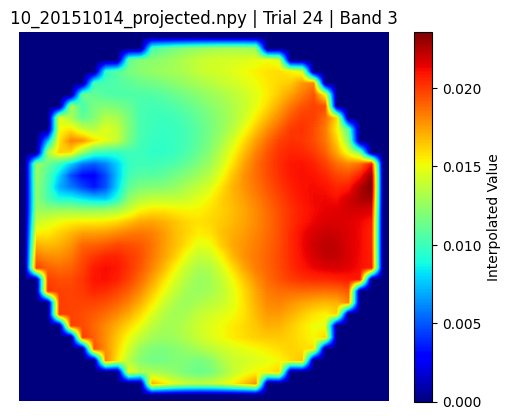

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the folder containing projected EEG files
projected_folder = '/content/drive/MyDrive/projected_images'

# Automatically pick the first projected file (or choose manually)
file_list = [f for f in os.listdir(projected_folder) if f.endswith('_projected.npy')]
if not file_list:
    raise FileNotFoundError("No projected .npy files found in the folder.")

# Load the first file (or change index)
file_to_load = os.path.join(projected_folder, file_list[0])
data = np.load(file_to_load)  # shape: (trials, 5, 32, 32)
print(f"📂 Loaded: {file_to_load} | Shape: {data.shape}")

# Choose trial and band to visualize
trial_idx = 23          # Trial index: 0 to data.shape[0]-1
band_idx = 2            # Band index: 0 (delta) to 4 (gamma), assuming order

# Plot the selected band image
plt.imshow(data[trial_idx, band_idx], cmap='jet', interpolation='bilinear')
plt.colorbar(label='Interpolated Value')
plt.title(f"{file_list[0]} | Trial {trial_idx+1} | Band {band_idx+1}")
plt.axis('off')
plt.show()



In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# === CBAM Module Definitions ===

class CBAM(nn.Module):
    def __init__(self, channel, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(channel, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x


class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).view(x.size(0), -1))
        max_out = self.fc(self.max_pool(x).view(x.size(0), -1))
        out = avg_out + max_out
        return x * out.view(out.size(0), out.size(1), 1, 1)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_out = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv1(x_out)
        return x * self.sigmoid(x_out)


# === CBAM Application on All Projected EEG Files ===

def apply_cbam_to_all(projected_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    # List all .npy files from projection
    file_list = sorted([f for f in os.listdir(projected_folder) if f.endswith('_projected.npy')])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cbam = CBAM(channel=5).to(device)

    for file_name in file_list:
        file_path = os.path.join(projected_folder, file_name)
        data = np.load(file_path)  # shape: (trials, 5, 32, 32)
        print(f"📥 Processing: {file_name} | Shape: {data.shape}")

        # Convert to tensor
        data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

        # Apply CBAM to each trial
        output_tensor = cbam(data_tensor)  # shape: (trials, 5, 32, 32)
        output_np = output_tensor.cpu().detach().numpy()

        # Save
        output_filename = file_name.replace('_projected.npy', '_cbam_output.npz')
        np.savez(os.path.join(output_folder, output_filename), cbam_output=output_np)
        print(f"✅ Saved: {output_filename} | Shape: {output_np.shape}")

# === Run the Function ===

apply_cbam_to_all(
    projected_folder='/content/projected_images',
    output_folder='/content/cbam_outputs_last'
)



In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers

# === Load Real CBAM Features ===
data_folder = '/content/cbam_features'
features_list, labels_list = [], []

for file in os.listdir(data_folder):
    if file.endswith('.npz'):
        data = np.load(os.path.join(data_folder, file))
        features_list.append(data['features'])  # (24, 5, 32, 32)
        labels_list.append(data['labels'])      # (24,)

real_features = np.concatenate(features_list, axis=0)
real_labels = np.concatenate(labels_list, axis=0)

real_features = np.expand_dims(real_features, axis=-1)  # (N, 5, 32, 32, 1)
real_features = (real_features.astype('float32') - 0.5) * 2  # Scale to [-1, 1]

num_classes = len(np.unique(real_labels))
latent_dim = 100
batch_size = 64
epochs = 10000

# === Build Generator ===
def build_generator():
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    combined = layers.multiply([noise_input, label_embedding])
    x = layers.Dense(128 * 8 * 8 * 8, activation='relu')(combined)
    x = layers.Reshape((8, 8, 8, 128))(x)  # (depth=8, height=8, width=8)

    # Upsample height/width ×2, keep depth same
    x = layers.Conv3DTranspose(128, (3, 4, 4), strides=(1, 2, 2), padding='same', activation='relu')(x)  # (8,16,16)

    # Upsample height/width ×2, shrink depth to 5
    x = layers.Conv3DTranspose(64, (4, 4, 4), strides=(1, 2, 2), padding='same', activation='relu')(x)  # (8,32,32)
    x = layers.Conv3D(64, (4, 4, 4), padding='same', activation='relu')(x)
    x = layers.Cropping3D(cropping=((1, 2), (0, 0), (0, 0)))(x)  # (5,32,32)

    x = layers.Conv3D(1, (3, 3, 3), activation='tanh', padding='same')(x)  # Final output: (5,32,32,1)

    model = Model([noise_input, label_input], x)
    return model


# === Build Discriminator ===
def build_discriminator():
    feature_input = layers.Input(shape=(5, 32, 32, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, 5 * 32 * 32)(label_input)
    label_embedding = layers.Reshape((5, 32, 32, 1))(label_embedding)

    combined = layers.Concatenate()([feature_input, label_embedding])
    x = layers.Conv3D(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu')(combined)
    x = layers.Conv3D(128, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model([feature_input, label_input], x)
    return model

# === Compile Models ===
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# IMPORTANT: Only freeze discriminator, NOT generator
discriminator.trainable = False

# Build combined model
z = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,), dtype='int32')
generated_feature = generator([z, label])
validity = discriminator([generated_feature, label])

combined_model = Model([z, label], validity)
combined_model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy')

# === Training Loop ===
for epoch in range(epochs):
    # ---- Train Discriminator ----
    idx = np.random.randint(0, real_features.shape[0], batch_size)
    real_imgs, real_labs = real_features[idx], real_labels[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_labels = np.random.randint(0, num_classes, batch_size)
    gen_imgs = generator.predict([noise, gen_labels], verbose=0)

    d_loss_real = discriminator.train_on_batch([real_imgs, real_labs], np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---- Train Generator ----
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, batch_size)
    valid_y = np.ones((batch_size, 1))

    g_loss = combined_model.train_on_batch([noise, sampled_labels], valid_y)

    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

# === Generate Synthetic Data ===
num_synthetic = 10000
z = np.random.normal(0, 1, (num_synthetic, latent_dim))
gen_labels = np.random.randint(0, num_classes, num_synthetic)
gen_imgs = generator.predict([z, gen_labels], verbose=1)
gen_imgs = (gen_imgs + 1) / 2  # scale back to [0, 1] if needed

# === Save Synthetic Data ===
np.savez('gan_cbam_synthetic_data.npz', features=gen_imgs, labels=gen_labels)
print("✅ Synthetic data saved as 'gan_cbam_synthetic_data.npz'")


0 [D loss: 34.8964, acc: 10.94%] [G loss: 0.6930]
100 [D loss: 23.5731, acc: 1.38%] [G loss: 0.6526]
200 [D loss: 23.5871, acc: 0.69%] [G loss: 0.5870]
300 [D loss: 23.6111, acc: 0.46%] [G loss: 0.5402]
400 [D loss: 23.6250, acc: 0.35%] [G loss: 0.5147]
500 [D loss: 23.6340, acc: 0.28%] [G loss: 0.4987]
600 [D loss: 23.6402, acc: 0.23%] [G loss: 0.4877]
700 [D loss: 23.6449, acc: 0.20%] [G loss: 0.4796]
800 [D loss: 23.6486, acc: 0.17%] [G loss: 0.4734]
900 [D loss: 23.6516, acc: 0.15%] [G loss: 0.4685]
1000 [D loss: 23.6540, acc: 0.14%] [G loss: 0.4644]
1100 [D loss: 23.6560, acc: 0.13%] [G loss: 0.4611]
1200 [D loss: 23.6578, acc: 0.12%] [G loss: 0.4582]
1300 [D loss: 23.6593, acc: 0.11%] [G loss: 0.4558]
1400 [D loss: 23.6606, acc: 0.10%] [G loss: 0.4537]
1500 [D loss: 23.6617, acc: 0.09%] [G loss: 0.4519]
1600 [D loss: 23.6627, acc: 0.09%] [G loss: 0.4503]
1700 [D loss: 23.6635, acc: 0.08%] [G loss: 0.4489]
1800 [D loss: 23.6644, acc: 0.08%] [G loss: 0.4476]
1900 [D loss: 23.6651, 

✅ Loaded real data: features shape (1080, 5, 32, 32), labels shape (1080,)
✅ Loaded synthetic data: features shape (10000, 5, 32, 32, 1), labels shape (10000,)
Combined dataset shape: (11080, 5, 32, 32, 1), Labels shape: (11080,)
X_train shape: (8864, 5, 32, 32, 1)
X_test shape: (2216, 5, 32, 32, 1)
y_train shape: (8864,)
y_test shape: (2216,)
X_combined shape: (11080, 5, 32, 32, 1)
y_combined shape: (11080,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 32, 32, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 32, 32, 32)  │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 16, 16, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 16, 16, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 8, 8, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 4096)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     2,163,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,532 (8.36 MB)

 Trainable params: 2,190,532 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.2640 - loss: 1.3894 - val_accuracy: 0.2523 - val_loss: 1.3752
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3476 - loss: 1.3569 - val_accuracy: 0.5014 - val_loss: 1.0896
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6610 - loss: 0.8981 - val_accuracy: 0.9030 - val_loss: 0.5211
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7722 - loss: 0.5228 - val_accuracy: 0.8394 - val_loss: 0.4130
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8178 - loss: 0.4223 - val_accuracy: 0.8353 - val_loss: 0.3448
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8705 - loss: 0.3295 - val_accuracy: 0.9264 - val_loss: 0.2838
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8993 - loss: 0.2593 - val_accuracy: 0.9152 - val_loss: 0.2057
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9088 - loss: 0.2123 - val_acc

✅ Model saved to /content/final_model.h5

✅ Final Test Accuracy: 0.9310
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

=== Classification Report ===
              precision    recall  f1-score   support

     Neutral     0.9454    0.9235    0.9343       562
         Sad     0.9828    0.9261    0.9536       555
        Fear     0.8208    0.9794    0.8931       533
       Happy     1.0000    0.8975    0.9460       566

    accuracy                         0.9310      2216
   macro avg     0.9372    0.9316    0.9317      2216
weighted avg     0.9387    0.9310    0.9322      2216



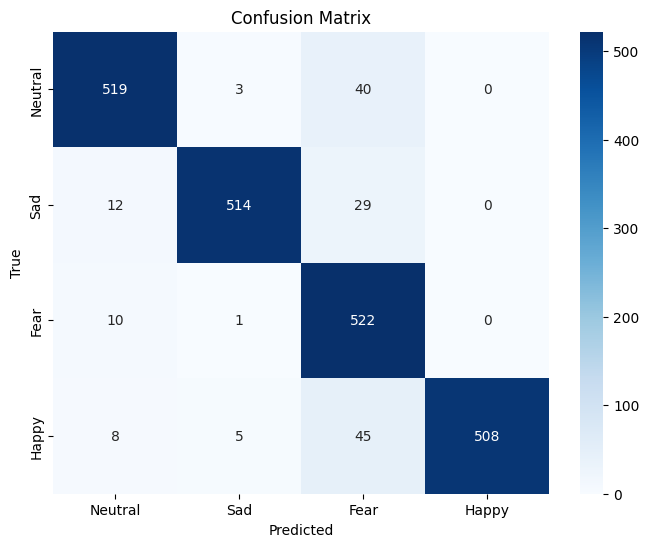

Final Accuracy: 0.9310


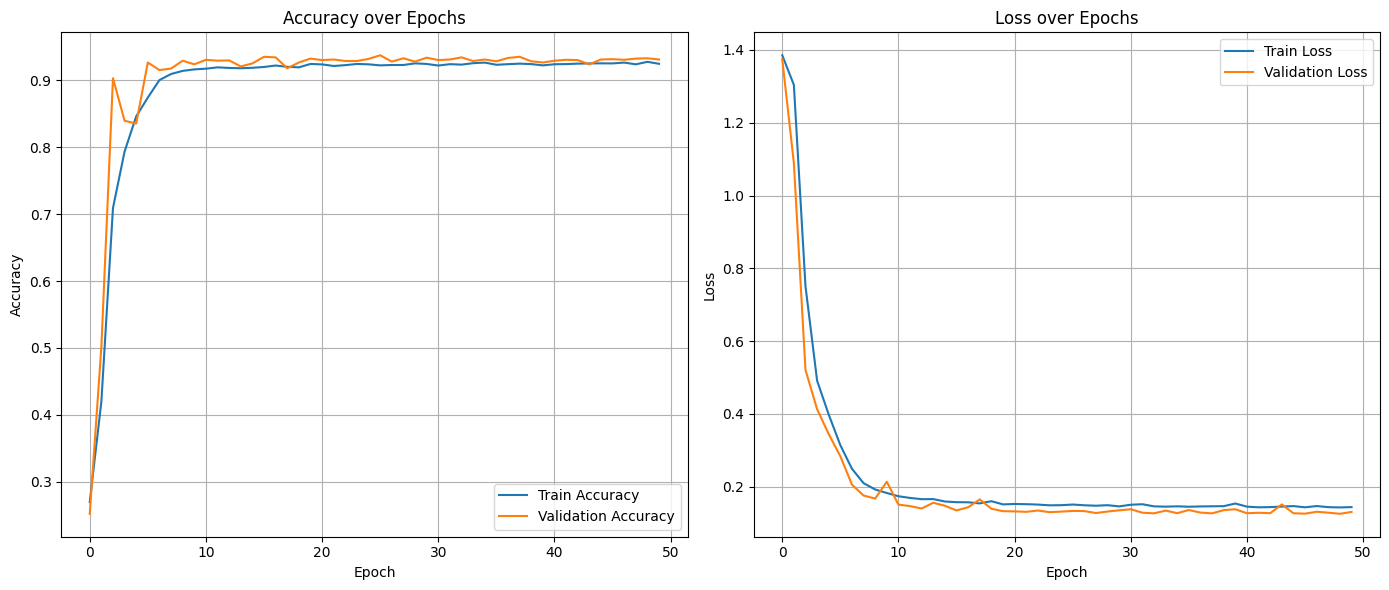

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt

# === Load All .npz Files from cbam_features_all Folder ===
data_folder = '/content/cbam_features'
features_list, labels_list = [], []

for file in os.listdir(data_folder):
    if file.endswith('.npz'):
        data = np.load(os.path.join(data_folder, file))
        features_list.append(data['features'])  # (24, 5, 32, 32)
        labels_list.append(data['labels'])      # (24,)

real_features = np.concatenate(features_list, axis=0)  # (N, 5, 32, 32)
real_labels = np.concatenate(labels_list, axis=0)      # (N,)

print(f"✅ Loaded real data: features shape {real_features.shape}, labels shape {real_labels.shape}")


synthetic_data = np.load('/content/gan_cbam_synthetic_data.npz')
synthetic_features = synthetic_data['features']  # (M, 5, 32, 32, 1)
synthetic_labels = synthetic_data['labels']      # (M,)

print(f"✅ Loaded synthetic data: features shape {synthetic_features.shape}, labels shape {synthetic_labels.shape}")

# Expand dims if needed
if real_features.ndim == 4:
    real_features = np.expand_dims(real_features, -1)

# Combine
X = np.concatenate([real_features, synthetic_features], axis=0)
y = np.concatenate([real_labels, synthetic_labels], axis=0)

print(f"Combined dataset shape: {X.shape}, Labels shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_combined shape: {X.shape}")
print(f"y_combined shape: {y.shape}")
num_classes = len(np.unique(y))
input_shape = X.shape[1:]

# === Compute Class Weights ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# === Build CNN + LSTM Model ===
def build_cnn_lstm(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)  # (5, 32, 32, 1)

    x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Flatten())(x)  # (batch, time, features)

    x = layers.LSTM(128, return_sequences=False)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn_lstm(input_shape, num_classes)
model.summary()

# === Train Model ===
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    verbose=1)

# === Save the Model ===
model_save_path = '/content/final_model.h5'
model.save(model_save_path)
print(f"✅ Model saved to {model_save_path}")

# === Evaluate Final Test Performance ===
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final Test Accuracy: {test_acc:.4f}")

# === Generate Classification Report ===
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_test, y_pred, target_names=['Neutral', 'Sad', 'Fear', 'Happy'], digits=4)
print("\n=== Classification Report ===")
print(report)

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Neutral', 'Sad', 'Fear', 'Happy'], yticklabels=['Neutral', 'Sad', 'Fear', 'Happy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# === Final Accuracy ===
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Final Accuracy: {accuracy:.4f}")

# === Plot Training and Validation Accuracy and Loss ===
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
